In [1]:
!which python

/Users/aaron/Documents/github/ssd-pytorch/venv/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
from albumentations import Compose, HorizontalFlip

from ssdmultibox import utils
from ssdmultibox.bboxer import Bboxer, TensorBboxer
from ssdmultibox.config import cfg
from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, device, TransformsTrainPascalFlatDataset
from ssdmultibox.models import SSDModel
from ssdmultibox.plotting import *
from ssdmultibox.predict import Predict
from ssdmultibox.utils import open_image

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cpu')

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-2

criterion = SSDLoss(alpha=.2)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
current_time = time.time()

In [7]:
BATCH = 8

TransformsTrainPascalFlatDataset.__len__ = lambda self: BATCH

train_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=1)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

len(train_dataset) 

8

In [8]:
train_dataset

In [9]:
NUM_WORKERS = 0
SHUFFLE = False
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TransformsTrainPascalFlatDataset at 0x1466f3c88>,
 'batch_size': 8,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x1466f3b38>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x1466f3cc0>,
 '_DataLoader__initialized': True}

In [10]:
EPOCHS = 1

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 928.2427 neg_hard_mining_loss: 2792.3477
n: 67.0 bbs_loss: 993.7760 cats_loss: 3720.5903
epoch: 0 step: 0 loss: 70.3637 time: 21.7806



In [11]:
bbs_preds, cats_preds = preds
idx = 1
cls_id = 6
dataset = train_dataset
model_output = image_ids, ims, gt_bbs, gt_cats

## single plots

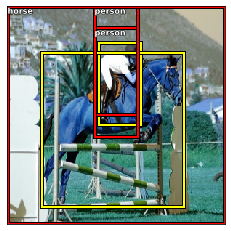

In [12]:
transform_plot_anchor_bbs(model_output, idx, dataset)

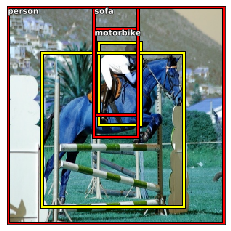

In [13]:
transform_plot_preds(model_output, idx, dataset, preds)

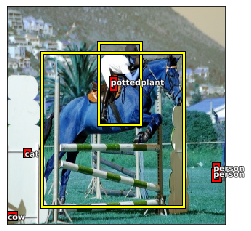

In [14]:
transform_plot_nms_preds(model_output, idx, dataset, preds)

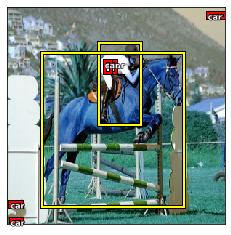

In [15]:
transform_plot_nms_single_preds(model_output, idx, dataset, preds, cls_id)

## multiple plots

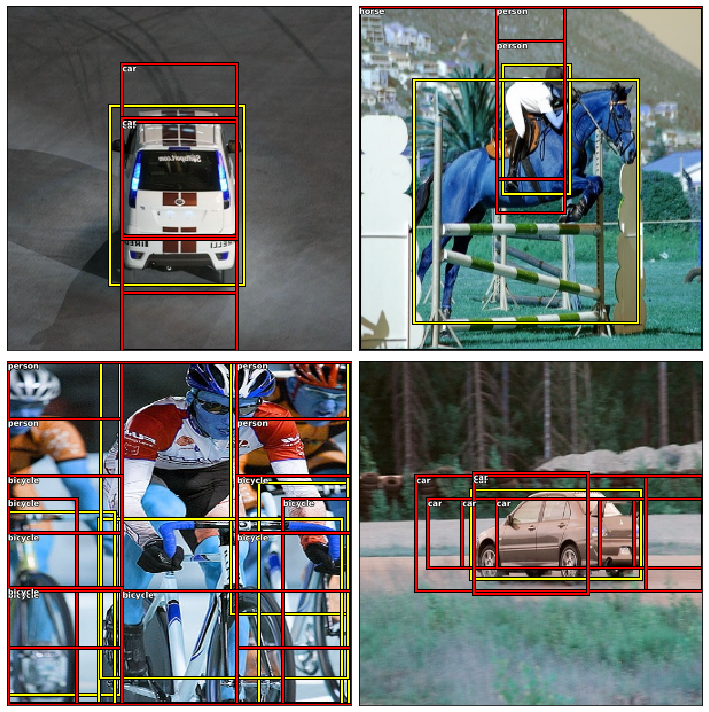

In [16]:
plot_multiple(transform_plot_anchor_bbs, model_output=model_output, dataset=dataset)

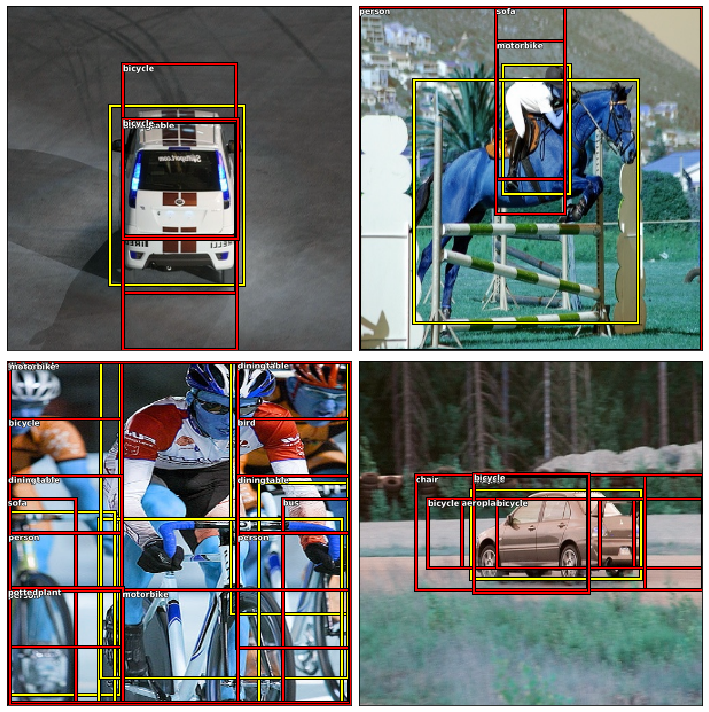

In [17]:
plot_multiple(transform_plot_preds, model_output=model_output, dataset=dataset, preds=preds)

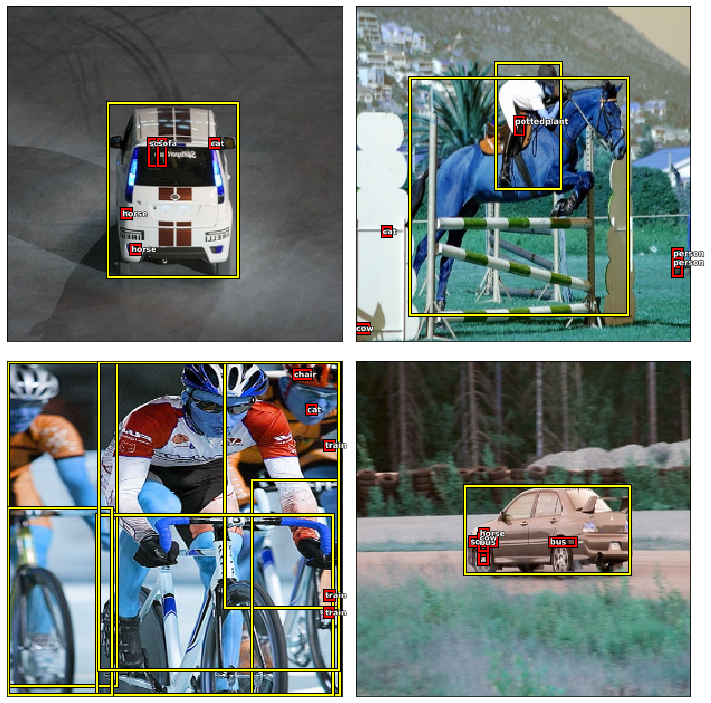

In [18]:
plot_multiple(transform_plot_nms_preds, model_output=model_output, dataset=dataset, preds=preds)

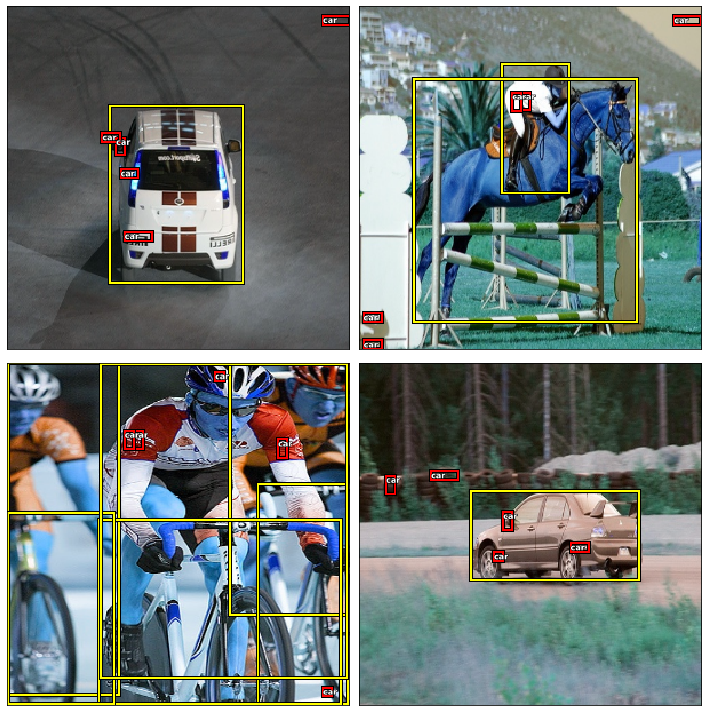

In [19]:
plot_multiple(transform_plot_nms_single_preds, model_output=model_output, dataset=dataset, preds=preds, cls_id=cls_id)